# TODO

- Deterministic
    - Will probably want to use generators when paralleizing


- Specular reflection
    
    
- Optimization
    - Make the code faster...
    - What data to store
        - Need to store cound electrons reaching contacts!!!
    
    
- Ohmstats and colormap plotting
    - Ohmstats line
    - Ease, speed, and correctness

# Init

In [1]:
%%capture

%load_ext line_profiler

import importlib
from cycler import cycler
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

import monte_carlo_simulation as mcs
importlib.reload(mcs)
from shapely.geometry import LineString
from shapely.geometry import Point

import cProfile

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

In [2]:
from enum import IntEnum

class TrajectoryState(IntEnum):
    INJECTING = 0
    ACTIVE = 1
    COLLISION = 2
    REINJECTING = 3
    ABSORBED = 4

state = TrajectoryState.ACTIVE
if state ==  TrajectoryState.ACTIVE:
    print('the state is active')

the state is active


In [3]:
trajectory = []

In [4]:

state = TrajectoryState.INJECTING
step_params = [(5, 6, 7, state)]
trajectory.append(step_params[0])
trajectory.extend(step_params)

In [5]:
trajectory

[(5, 6, 7, <TrajectoryState.INJECTING: 0>),
 (5, 6, 7, <TrajectoryState.INJECTING: 0>)]

In [6]:
ns, xs, ys, state = zip(*trajectory)

# Simulation

## Bar

python multiprocessing
monte carlo git library

In [7]:
k = delafossite()
bar_frame = caustic_frame.Frame('geo/bar.dxf')
bar_sim = mcs.Simulation(bar_frame, k, 0, 15, 10)
#bar_sim.set_seed(0)

In [8]:
bar_trajectories = bar_sim.run_simulation(10, debug=True)

/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:266: RuntimeWarning: divide by zero encountered in true_divide
  (x01*self._frame.y23 - y01*self._frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:267: RuntimeWarning: divide by zero encountered in true_divide
  us = -(x01*y02 - y01*x02) / (x01*self._frame.y23 - y01*self._frame.x23)


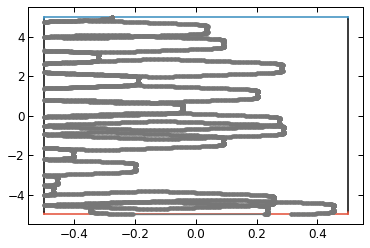

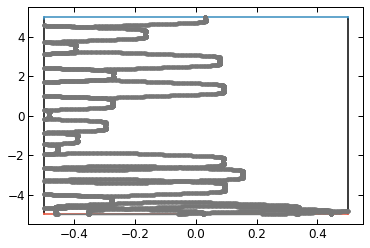

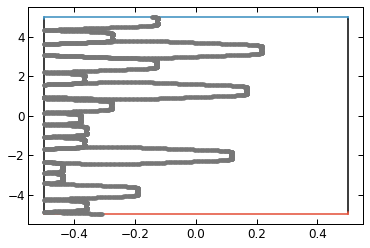

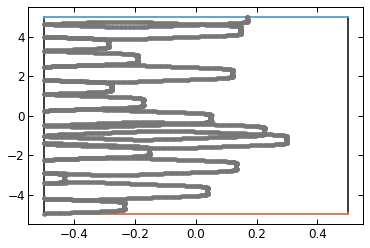

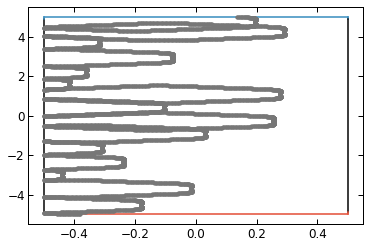

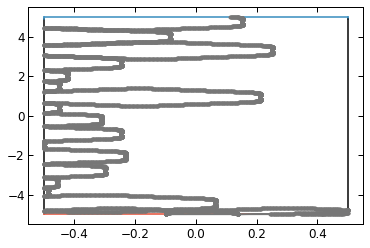

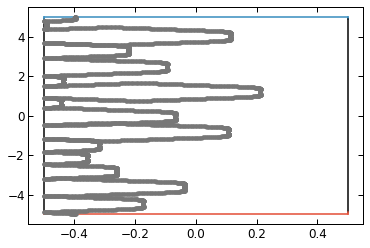

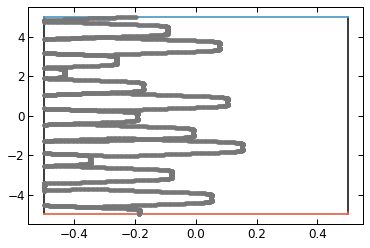

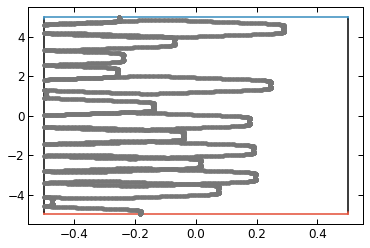

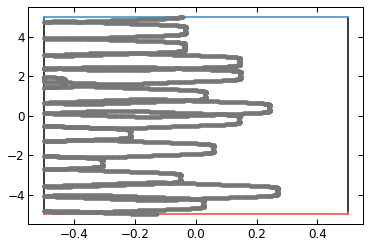

In [10]:
for trajectory in bar_trajectories:
    fig = bar_frame.gen_fig()
    ns, xs, ys, state = zip(*trajectory)
    plt.plot(xs,ys, 'C3.-')
    #plt.axes().set_aspect('equal')
    #plt.ylim(-5.1,-4)

In [11]:
state

(<TrajectoryState.INJECTING: 0>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <TrajectoryState.ACTIVE: 1>,
 <Traje

In [ ]:
num_edges = len(bar_frame.edges)
x = 0
y = 0
x_new = 0.5
y_new = 3

x01 = x - x_new
y01 = y - y_new
x02 = x - bar_frame.px0
y02 = y - bar_frame.py0
x_del = x_new - x
y_del = y_new - y

ts = (x02*bar_frame.y23 - y02*bar_frame.x23) / (x01*bar_frame.y23 - y01*bar_frame.x23)
us = -(x01*y02 - y01*x02) / (x01*bar_frame.y23 - y01*bar_frame.x23)

intersections = []
for i, (t, u) in enumerate(zip(ts, us)):
    if 0 <= t and t <= 1 and 0 <= u and u <= 1:
        print(u, t)
        edge = bar_frame.edges[i]
        if x_del * edge.normal[0] + y_del * edge.normal[1] < 0:
            x_int = edge.xs[0] + u*(edge.xs[1] - edge.xs[0])
            y_int = edge.ys[0] + u*(edge.ys[1] - edge.ys[0])
            
            x_t = x + t*(x_new - x)
            y_t = y + t*(y_new- y)
            if x_int != x or y_int != y:
                bias_vector = 1E-10 * \
                    np.array([(x_new-x), (y_new-y)]) / \
                    np.sqrt((x_new-x)**2 + (y_new-y)**2)
                intersections.append(
                    (edge, x_int - bias_vector[0], y_int - bias_vector[1]))
    
print(x_int, y_int)
print(x_t, y_t)

In [ ]:
cmap = plt.get_cmap('Spectral_r')

for edge in bar_frame.edges:
    max_p = np.max(edge.in_prob)
    colors = np.array([cmap(p/max_p) for p in edge.in_prob])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig, ax = plt.subplots()
    plt.plot((0, (np.max(bar_sim._bandstructure.k[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), (0, (np.max(bar_sim._bandstructure.k[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
    plt.scatter(bar_sim._bandstructure.k[0], bar_sim._bandstructure.k[1],c=colors)
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    ax.set_aspect('equal')

In [ ]:
#%lprun -f bar_sim.get_sorted_intersections -f bar_sim.get_intersections -f bar_sim.step_position bar_sim.run_simulation(debug=False)

In [ ]:
cProfile.runctx("bar_sim.run_simulation(10, debug=False)", globals(), locals(), sort='cumtime')

In [ ]:
bar_trajectories = bar_sim.run_simulation(10, debug=True)

## TEF

In [ ]:
k = delafossite()
frame = caustic_frame.Frame('geo/tef.dxf')
sim = mcs.Simulation(frame, k, 0, -1, 10)

In [ ]:
%lprun -f sim.run_simulation -f sim._get_sorted_intersections -f sim._get_intersections -f sim._step_position sim.run_simulation(10, debug=False)

In [ ]:
t0 = time.time()
trajectories = sim.run_simulation(10, debug=False)
t1 = time.time()
print(t1-t0)

In [ ]:
for trajectory in trajectories:
    fig = frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3')
    #plt.xlim(-3.5, 1.75)
    #plt.ylim(-5.3, -4)